# YOLOv8 Baseline-Storm Damage Assessment (Kaggle Version)
# Inference Notebook

Prepared by: Hazman Naim

Version13-3/3/2024

Model Used: 240304-YOLOv8s

# 1. Preparing Inference Dataset

The inference dataset is already organized and is hosted in a private GitHub repository (which will be made public after the competition ends). To access these files, you must become an authorized member of the organization that owns the repository.

To access the repository, you will need to `git clone` the `storm-assessment-clean` repository. This repository contains the refined and cleaned work of our team for the storm damage assessment project.

To `git clone` a private repository, you will need a GitHub Private Access Token (PAT) to access the GitHub API. Create your PAT token [here](https://github.com/settings/tokens).

Store your PAT token in "Add-Ons > Secrets". Refer [here](https://www.youtube.com/watch?v=6gkLPC14_tI&ab_channel=Kaggle). 

Remember, DO NOT EVER EXPOSE YOUR SECRET TOKEN. This applies to Kaggle, Colab, or any other platform.

## 1.1 Import the Dataset

Import Kaggle UserSecretsClient to access the "Secrets".

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Github PAT")

Use `git clone` to fetch the raw dataset into our kernel.

In [2]:
!git clone https://{secret_value_0}@github.com/EY-Groupie2024WG/storm-assessment-clean.git

Cloning into 'storm-assessment-clean'...
remote: Enumerating objects: 21629, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 21629 (delta 72), reused 158 (delta 65), pack-reused 21463
Receiving objects: 100% (21629/21629), 1.00 GiB | 36.13 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Updating files: 100% (21482/21482), done.


Change the "current directory" to the "inference" directory in the `storm-assessment-clean` repository.

In [3]:
%cd storm-assessment-clean/inference

/kaggle/working/storm-assessment-clean/inference


# 2. Model Inference

For our project, we have chosen YOLO (You Only Look Once) as the baseline model for training. YOLO is a state-of-the-art object detection algorithm known for its speed and accuracy, making it well-suited for real-time applications.

## 2.1 Import Packages and Libraries

Import YOLO from Ultralytics.

In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.22 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5518.9/8062.4 GB disk)


Install dependencies.

In [5]:
!pip install imagesize
!pip install ptitprince

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 5.7 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10655 sha256=4f63dfc7bc8b0f337ca8964d580470127159c7ad54fa7c47122c2785697b2997
  Stored in directory: /root/.cache/pip/wheels/0e/43/31/e76a3bf61865543f076a9d9eb027a740caefb379424ecba4e8
Successfully built ptitprince
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [6]:
from ultralytics import YOLO
import pandas as pd
from IPython.display import display, Image
import shutil

import os
import re
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)

## 2.2 Load the Model

We will begin by loading the trained weights for our YOLO model. Refer to the Training notebook for the training workflow.

In [7]:
# If you interrupt the inference process, run this.
!rm -rf /kaggle/working/storm-assessment-clean/inference/runs

To start our inference, we will load the trained model.


In [8]:
# Load a model
model = YOLO("weight/yolov8s_storm_240304.pt")  # load a trained model

## 2.3 Making Predictions on the Submission Data

In [9]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'undamagedresidentialbuilding', 
                          1: 'damagedresidentialbuilding', 
                          2: 'undamagedcommercialbuilding', 
                          3: 'damagedcommercialbuilding'}

inference_directory = 'inference_dataset'

# Directory to store outputs
results_directory = 'inference_result'

In [10]:
# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)


In [11]:
# Loop through each file in the directory
for filename in os.listdir(inference_directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(inference_directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(inference_directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.cpu().numpy().tolist()
            clss_list = r.boxes.cls.cpu().numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

            bounding_boxes = r.boxes.xyxy.cpu().numpy()
            confidences = conf_list
            class_names = updated_list

            # Check if bounding boxes, confidences and class names match
            if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
                print("Error: Number of bounding boxes, confidences, and class names should be the same.")
                continue
            text_file_name = os.path.splitext(filename)[0]
            # Creating a new .txt file for each image in the results_directory
            with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
                for i in range(len(bounding_boxes)):
                    # Get coordinates of each bounding box
                    left, top, right, bottom = bounding_boxes[i]
                    # Write content to file in desired format
                    file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")

inference_dataset/Validation_Post_Event_010.jpg
Making a prediction on  Validation_Post_Event_010.jpg

image 1/1 /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_010.jpg: 512x512 7 undamagedresidentialbuildings, 7 undamagedcommercialbuildings, 2 damagedcommercialbuildings, 366.4ms
Speed: 6.4ms preprocess, 366.4ms inference, 24.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Output files generated successfully.
inference_dataset/Validation_Post_Event_012.jpg
Making a prediction on  Validation_Post_Event_012.jpg

image 1/1 /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_012.jpg: 512x512 22 undamagedresidentialbuildings, 1 damagedresidentialbuilding, 3 undamagedcommercialbuildings, 1 damagedcommercialbuilding, 248.9ms
Speed: 1.6ms preprocess, 248.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
Results sav

Check the Result. Copy and Replace:

* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_012.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_004.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_005.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_003.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_011.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_002.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_001.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_010.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_007.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_009.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_008.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_006.jpg
* /kaggle/working/storm-assessment-clean/inference/inference_dataset/Validation_Post_Event_012.jpg


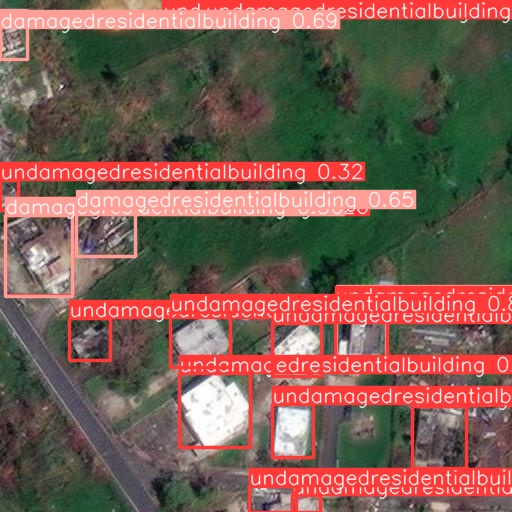

In [12]:
# Path to the PNG file
result_png_path = "/kaggle/working/storm-assessment-clean/inference/runs/detect/predict/Validation_Post_Event_002.jpg"

# Display the PNG file
Image(result_png_path)

Visualize all

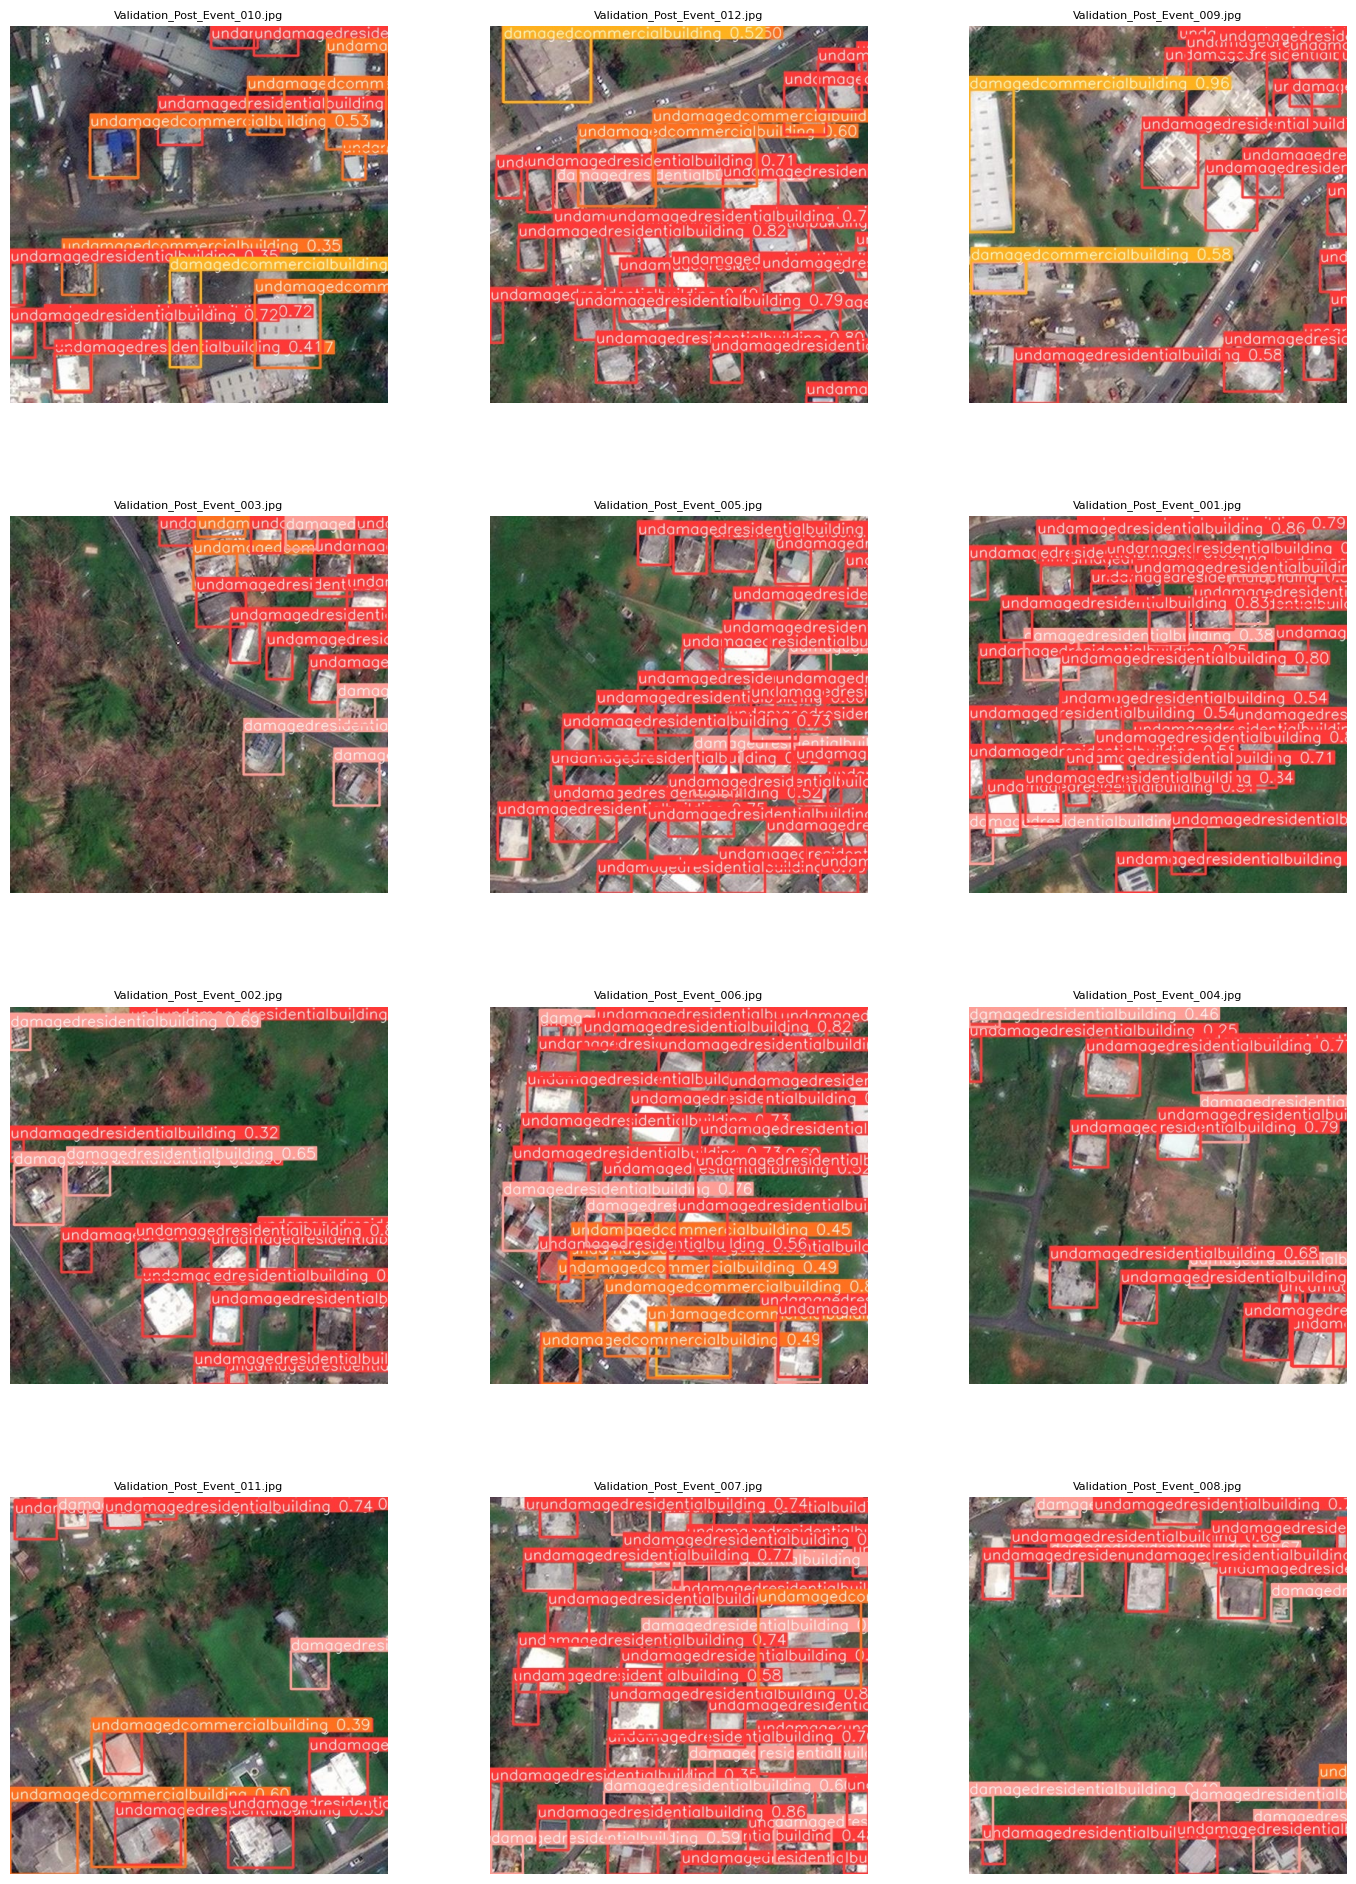

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing the .jpg files
directory = "/kaggle/working/storm-assessment-clean/inference/runs/detect/predict/"

# Get all .jpg files in the directory
jpg_files = [file for file in os.listdir(directory) if file.endswith(".jpg")]

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = (len(jpg_files) // num_rows) + (len(jpg_files) % num_rows)

# Define the size of each image
image_size = 6

# Create subplots with larger figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * image_size, num_rows * image_size))

# Flatten the axes if needed
axes = axes.flatten()

# Loop through each .jpg file and display it
for i, jpg_file in enumerate(jpg_files):
    # Construct the full path
    jpg_path = os.path.join(directory, jpg_file)
    
    # Read and display the image
    img = Image.open(jpg_path)
    axes[i].imshow(img)
    axes[i].set_title(jpg_file, fontsize=8)  # Set smaller font size for the title
    axes[i].axis('off')

# Adjust layout
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Reduce the spacing between rows
plt.show()


# 3. Preparaing the Result as Submission

Now, we compile all the results and zip into a zip file which will be used for submission.

In [14]:
# Define your source directory and the destination where the zip file will be created
source_dir = results_directory
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory inference_result has been successfully zipped into submission.


## Thank You and All the Best!!!!!!!!!

![Alt Text](https://media1.tenor.com/m/ovWTVvG3VBwAAAAd/mr-fresh-mr-fresh-multiverse.gif)


Training notebook is [here](https://www.kaggle.com/code/hazmannaim/yolov8-baseline-storm-damage-assessment-training)